<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/MURA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mura dataset
---
### Data:
Train and validation data for XR_HUMERUS from MURA dataset. \

---
### Code parts(description of colab cells):
**Imports** - contain all used imports with descriptions \
**Experimental** - code for experimenting with new features but is not currenly used in production version \
**Colab essentials** - when running code on Colab, mount Google Drive so data can be read from there. \
**Constants declaration** - declaring input parameters \
**Data augmentation** - defining functions for importing and augmenting data in Keras \
**Auxiliary functions** - any functions non-related to ML training, usually for graphical output \
**Model definitions** - Defining keras models \
**Training model** - initialization and training model






## Imports


In [0]:
# For graphical outpus, images preview and training results plot representation
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generator used for loading data into Keras model
from keras.preprocessing.image import ImageDataGenerator

# Essentials for creating model architecture, model class, layers and optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.initializers import he_uniform 
# Logger for logging results from training model
from keras.callbacks import CSVLogger

# System functions and path processing
import sys
import os

# Support functions for saving and loading model
from keras.models import load_model
from keras.utils import plot_model

Using TensorFlow backend.


## Experimental


#### Experimental settings for GPU training
Currently not working

In [0]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)

#     except RuntimeError as e:
#         print(e)

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [0]:
# print(device_lib.list_local_devices())

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

#### function for replacing layers in Model

In [0]:

# Function to replace/remove/add layer from Model (class Model, not Sequential)
# import re
# from keras.models import Model
# def return_dense_2():
#   return Dense(2, activation='softmax')

# def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
#                       insert_layer_name=None, position='after'):

#   # Auxiliary dictionary to describe the network graph
#   network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

#   # Set the input layers of each layer
#   for layer in model.layers:
#       for node in layer._outbound_nodes:
#           layer_name = node.outbound_layer.name
#           if layer_name not in network_dict['input_layers_of']:
#               network_dict['input_layers_of'].update(
#                       {layer_name: [layer.name]})
#           else:
#               network_dict['input_layers_of'][layer_name].append(layer.name)

#   # Set the output tensor of the input layer
#   network_dict['new_output_tensor_of'].update(
#           {model.layers[0].name: model.input})

#   # Iterate over all layers after the input
#   for layer in model.layers[1:]:

#       # Determine input tensors
#       layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
#               for layer_aux in network_dict['input_layers_of'][layer.name]]
#       if len(layer_input) == 1:
#           layer_input = layer_input[0]

#       # Insert layer if name matches the regular expression
#       if re.match(layer_regex, layer.name):
#           if position == 'replace':
#               x = layer_input
#           elif position == 'after':
#               x = layer(layer_input)
#           elif position == 'before':
#               pass
#           else:
#               raise ValueError('position must be: before, after or replace')

#           new_layer = insert_layer_factory()
#           if insert_layer_name:
#               new_layer.name = insert_layer_name
#           else:
#               new_layer.name = '{}_{}'.format(layer.name, 
#                                               new_layer.name)
#           x = new_layer(x)
#           print('Layer {} inserted after layer {}'.format(new_layer.name,
#                                                           layer.name))
#           if position == 'before':
#               x = layer(x)
#       else:
#           x = layer(layer_input)

#       # Set new output tensor (the original one, or the one of the inserted
#       # layer)
#       network_dict['new_output_tensor_of'].update({layer.name: x})

#   return Model(inputs=model.inputs, outputs=x)

# densenet_model = insert_layer_nonseq(densenet_model, 'fc1000', return_dense_2, insert_layer_name='Dense_2', position='replace')
# densenet_model.compile(optimizer='adam',
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

## Colab essentials
Running code on Colab and local requires slightly different, prerequisites (as different paths, etc.)
For differentiating where code is run, variable IN_COLAB is used, if True then run is in Colab (so rest of code can reflect that)

In [0]:
# check if code run on colab or local, if in Colab then True
IN_COLAB = 'google.colab' in sys.modules

# if run in Colab, then mount to run Google Drive file system
if IN_COLAB:
  # Mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##  Constants declaration


##### Constants that are expected to be directly changed (input parameters)

In [0]:
PATH_ORIGINAL_DATA="/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"
COMMON_PATH = "/content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/"

PATH_DESTINATION_CROPPED_RECT = COMMON_PATH + "cropped_rect/"
PATH_DESTINATION_CROPPED_SQUARE = COMMON_PATH + "cropped_square/"
PATH_DESTINATION_HIST_EQ = COMMON_PATH + "hist_eq/"
PATH_DESTINATION_CLAHE = COMMON_PATH + "clahe/"
# cropped_rect_clahe shows so far best results, currently used
PATH_DESTINATION_CROPPED_RECT_CLAHE = COMMON_PATH + "cropped_rect_clahe/"
PATH_DESTINATION_CROPPED_SQUARE_CLAHE = COMMON_PATH + "cropped_square_clahe/"

# Path to file with input data (and where outputs will be saved)
PATH = PATH_DESTINATION_CROPPED_RECT_CLAHE

IMG_SIZE=(224,224)
INPUT_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 32
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 30

##### Deriving other constants from given values

In [0]:
def files_number(PATH):
  """find number of files(recursively) in given directory(path)"""
  total = 0
  for root, dirs, files in os.walk(PATH):
      total += len(files)
  return total

# if run on local machine, change path to correspond my local system paths
if not IN_COLAB:
  PATH = "G:"+PATH[14:].replace('/', '\\\\')

PATH_TRAIN = PATH + 'train'
PATH_VALID = PATH + 'valid'
# calculate number of steps per epoch and validation steps from input values
# and constants
NUMBER_STEPS_PER_EPOCH = files_number(PATH_TRAIN) // BATCH_SIZE
NUMBER_VALIDATION_STEPS = files_number(PATH_VALID) // BATCH_SIZE

print("Number of steps per epoch:", NUMBER_STEPS_PER_EPOCH)
print("Number of validation steps:", NUMBER_VALIDATION_STEPS)

Number of steps per epoch: 39
Number of validation steps: 8


## Data augmentation
Currently image augmentation will be done by parameters of ImageDataGenerator.
If in future this solution will be insufficient, I will change it.

In [0]:
def ImageDataGenerator_def():
  datagen = ImageDataGenerator(
    # featurewise_center=False,  # set input mean to 0 over the dataset
    # samplewise_center=False,  # set each sample mean to 0
    # featurewise_std_normalization=False,  # divide inputs by std of the dataset
    # samplewise_std_normalization=False,  # divide each input by its std
    # zca_whitening=False,  # apply ZCA whitening
    # zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically` (fraction of total height)
    height_shift_range=0.1,
    # shear_range=0.05,  # set range for random shear
    zoom_range=0.05,  # set range for random zoom
    # channel_shift_range=0.,  # set range for random channel shifts
    # # set mode for filling points outside the input boundaries
    # fill_mode='nearest',
    # cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    # vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=1. / 255,
    # # set function that will be applied on each input
    # preprocessing_function=None,
    # # image data format, either "channels_first" or "channels_last"
    # data_format=None,
    # # fraction of images reserved for validation (strictly between 0 and 1)
    # validation_split=0.0
  )
  return datagen

def load_from_directory(dir_path, data_generator):
  '''Load images from directory while transforming data (based on parameters),
  contain other parameters for data augmentation'''
  batches = data_generator.flow_from_directory(
    # path to target directory from which data will be loaded
    dir_path,
    # resize all input images to IMG_SIZE
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    # class_mode='categorical',
    # color_mode='grayscale'
  )
  return batches

In [0]:


data_generator = ImageDataGenerator_def()

train_batches = load_from_directory(PATH_TRAIN, data_generator)
valid_batches = load_from_directory(PATH_VALID, data_generator)

print("Found indices: ", end='')
print(train_batches.class_indices)
# print(train_batches.class_indices)

Found 1271 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Found indices: {'train_negative': 0, 'train_positive': 1}


## Auxiliary functions

In [0]:
def label_to_string(label):
  '''Map label value to descriptive string'''
  if(label == 0):
    return "Negative"
  else:
    return "Positive"

def show_sample_images():
  '''Show one batch of training images (max 25 images)'''
  image_batch, label_batch = train_batches.next()
  plt.figure(figsize=(10,10))
  for n in range(min(len(image_batch), 25)):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n][:,:,0], cmap=cm.gray)
    plt.title(label_to_string(label_batch[n]))
    plt.axis('off')
  plt.show()

def load_model():
  '''Return loaded model saved model, based on value of PATH'''
  return load_model(PATH+"latest_model.h5")

def plot_model_graph():
  '''Print to output and save to file the graph of model layers
  and its parameters, based on value of PATH'''
  plot_model(loaded_model, to_file=PATH+"model_arch.png", show_shapes=True)

def plot_training(history):
  '''Plot diagnostic learning curves, print them to output and save them
   to file'''
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['acc'], color='blue', label='train')
	plt.plot(history.history['val_acc'], color='orange', label='test')
 	plt.set_ylim(bottom=0)
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(PATH + "batch_size_" + str(BATCH_SIZE) + 'svg_plot.png')
	plt.show()
	plt.close()

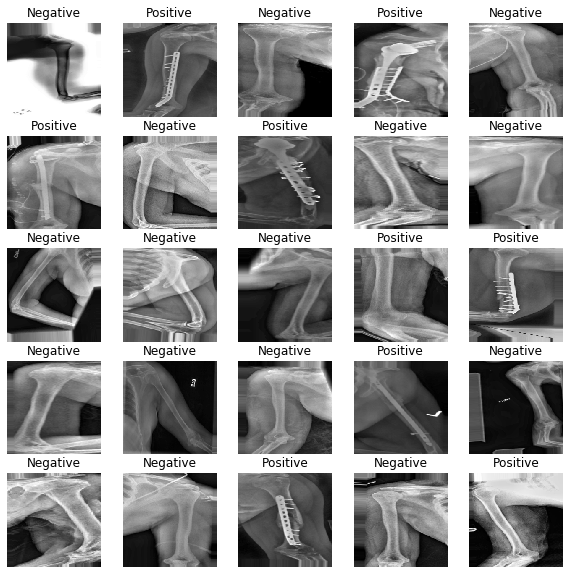

In [0]:
show_sample_images()

## Model definitions

#### Currently used model

In [0]:
# TODO describe every parameter what does it do
'''
Activation function is method that define the output of neuron, different
functions use distinctive methods of how to figure out output.
I am using ReLU - Rectified linear unit. It is simple but effective function,
x = max(0,x)'''
ACTIVATION_FUNCTION='relu'

'''Kernel initializer define method used in setting the initial random weights
in layers. 
Currently using he_uniform, draws samples from a uniform distribution within
[-limit, limit] where limit is sqrt(6 / fan_in) where fan_in
is the number of input units in the weight ten'''
KERNER_INITIALIZER=he_uniform(0)

'''
Padding is a method to extend input image, so filter kernel can work as intended
even around borders.
Same - is method that guarantee output have SAME spatial dimensions as input'''
PADDING='same'

'''Optimizer is algorithm that change the attributes of neural network
 (weights and learning rate) in order to reduce loss value
 Stochastic gradient descent'''
OPTIMIZER=SGD(lr=0.01, momentum=0.9)

'''Loss function evaluate loss/cost of specific event, in this case 
loss function describe how well does model perform'''
LOSS_FUNCTION='binary_crossentropy'

def three_block_VGG():
  """Three Block VGG Model"""
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER, padding=PADDING, input_shape=INPUT_SHAPE))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER, padding=PADDING))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER, padding=PADDING))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation=ACTIVATION_FUNCTION, kernel_initializer=KERNER_INITIALIZER))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=['accuracy'])
  return model

#### Other models (not currently used)

In [0]:
def basic_model():
  """Simple model, can't properly distinguish positive and negative images"""
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
  model.add(Flatten())
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

def simple_deep_CNN():
  """Simple deeper model, can distuingish positive and negative images, 
  however with poor results"""
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=INPUT_SHAPE))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUMBER_CLASSES))
  model.add(Activation('softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

def VGG16():
  '''Keras implentation of VGG16'''
  vgg16 = keras.applications.vgg16.VGG16()
  model = Sequential()
  for layer in vgg16.layers:
    model.add(layer)
  model.layers.pop()
  # for layer in model.layers:
  #   layer.trainable = False
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

def densenet():
  """Pre-trained Densenet201 from Keras library, with added layers to fit
  my classification problem"""
  densenet_model = keras.applications.densenet.DenseNet201(input_shape=INPUT_SHAPE,
                                              include_top=False, 
                                                weights='imagenet')
  densenet_model.trainable=False

  new_densenet = Sequential([
    densenet_model,
    Flatten(),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
  ])

  new_densenet.compile(optimizer=Adam(lr=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  return new_densenet

## Training model

In [0]:
# initialize model
model = three_block_VGG()

# print summary info about model and its layers
model.summary()

In [0]:
csv_logger = CSVLogger(PATH+'augmented_log.csv', append=True, separator=';')

# train model, as input takes training data, validation data
# steps per epoch, validations steps per epoch and number of epochs
# callbacks is used for logging output to file
history = model.fit_generator(train_batches,
                    steps_per_epoch= NUMBER_STEPS_PER_EPOCH,
                    validation_data = valid_batches,
                    validation_steps = NUMBER_VALIDATION_STEPS,
                    epochs = NUMBER_EPOCHS,
                    callbacks=[csv_logger])  

Epoch 1/30
39/39 [==============================] - 50s 1s/step - loss: 1.0095 - accuracy: 0.5577 - val_loss: 0.6850 - val_accuracy: 0.4883
Epoch 2/30
39/39 [==============================] - 54s 1s/step - loss: 0.6933 - accuracy: 0.5085 - val_loss: 0.6928 - val_accuracy: 0.4980
Epoch 3/30
39/39 [==============================] - 53s 1s/step - loss: 0.6895 - accuracy: 0.5359 - val_loss: 0.7005 - val_accuracy: 0.5176
Epoch 4/30
39/39 [==============================] - 52s 1s/step - loss: 0.6861 - accuracy: 0.5537 - val_loss: 0.6570 - val_accuracy: 0.5765
Epoch 5/30
39/39 [==============================] - 51s 1s/step - loss: 0.6860 - accuracy: 0.5569 - val_loss: 0.6389 - val_accuracy: 0.5961
Epoch 6/30
39/39 [==============================] - 50s 1s/step - loss: 0.6834 - accuracy: 0.5666 - val_loss: 0.6634 - val_accuracy: 0.6314
Epoch 7/30
39/39 [==============================] - 50s 1s/step - loss: 0.6755 - accuracy: 0.5857 - val_loss: 0.6398 - val_accuracy: 0.5725
Epoch 8/30
39/39 [==

In [0]:
# Save created model
model.save(PATH+"latest_model.h5")

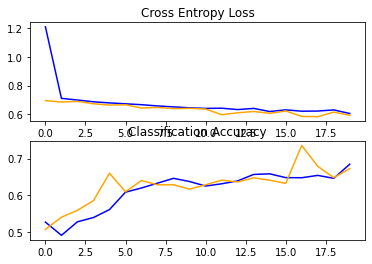

In [0]:
# show plots of loss/val_loss and accuracy/val_accuracy
plot_training(history)